# Case Study: Interpolating Precipitation Data with Spatialize
On this document, the tools **`esi_hparams_search`** and **`esi_nongriddata`** will be employed to estimate daily precipitation over the Maipo Basin in Chile.

The ESI implementation for non-gridded data enables interpolation on a 2.5D scenario (a curved surface), as opposed to the more common 2D (flat surface) and 3D (volume) scenarios.

## Setup

We'll start by loading the required libraries and inputs.

In [1]:
# === Libraries ===
import sys
sys.path.append('../')
from utils import PrecipitationCaseStudy, SuppressOutput

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Importar ESI desde repositorio, no desde instalación python, borrar antes de publicar!!
import import_helper
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

import numpy as np
import pandas as pd

# Spatialize:
from spatialize.gs.esi import esi_hparams_search, esi_nongriddata
import spatialize.gs.esi.lossfunction as lf

# Other interpolators:
from scipy.interpolate import griddata, RBFInterpolator
from sklearn.model_selection import GridSearchCV
from pykrige.rk import Krige

# Plots:
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

sns.set_theme(context='notebook', style='whitegrid')
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Load case study
case_study = PrecipitationCaseStudy()

# ESI inputs
points, values, xi = case_study.model_inputs()


Since we are working with a real, geolocated scenario, we'll create a plot format function and set some parameters to ease plotting.

## Visualizing the Input Data
Let us now visualise the data we have just loaded.

### Precipitation Data

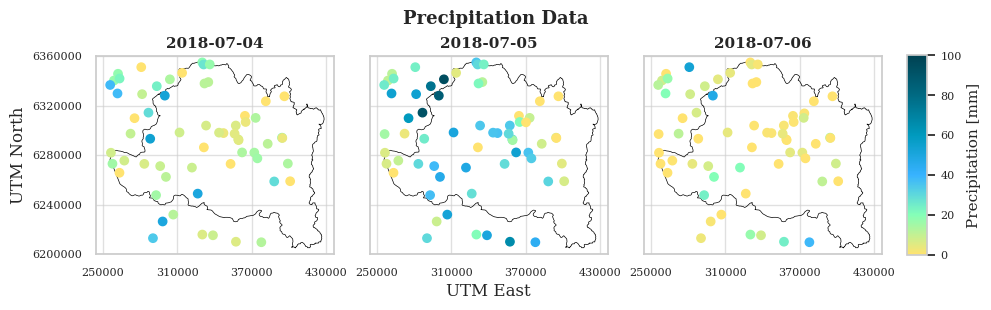

In [12]:
fig, axs = case_study.plot_input_data()
plt.show()


### Interpolation Locations

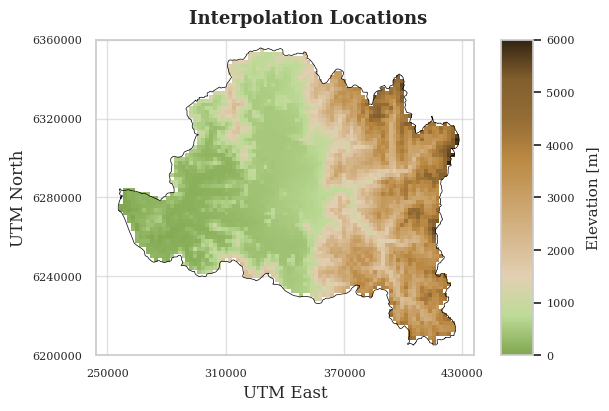

In [13]:
fig, ax = case_study.plot_interpolation_locations()
plt.show()


## Using ESI
In this section, we will implement the ESI algorithm to derive precipitation estimates across the whole surface of the Maipo Basin within three different dates.

**Modelling Setup**
- Inverse Distance Weighting (IDW) will be used as local interpolator. 
- The `esi_hparams_search` function will be used to identify optimal parameters for the `esi_nongriddata` function.
- Operational Error will be utilized for measuring uncertainty.

In [3]:
# To store results
esi_results = case_study.locs.copy()
esi_results.columns = pd.MultiIndex.from_tuples([(x, '') for x in esi_results.columns])

# To store parameters
parameters_idw = []

for date in case_study.dates:
    # Loss function: Operational error for the observed dynamic range
    op_error = lf.OperationalErrorLoss(np.abs(np.nanmin(values[date]) - np.nanmax(values[date])))

    # Searching for optimal parameters
    search_params = {'alpha': [0.7, 0.75, 0.8, 0.85, 0.9],
                     'exponent': np.round(np.arange(0.5, 3.1, 0.1), 1)}
    
    search_result = esi_hparams_search(points[date],
                                       values[date],
                                       xi,
                                       griddata=False,
                                       k=-1,
                                       n_partitions=[100],
                                       local_interpolator="idw",
                                       seed=1500,
                                       **search_params)
    
    best_params = search_result.best_result()

    # Using ESI
    result = esi_nongriddata(points=points[date],
                             values=values[date],
                             xi=xi,
                             n_partitions=300,
                             best_params_found=best_params,
                             seed=1500)

    # Store results
    #esi_results[(date, 'value')] = result._estimation
    esi_results[(date, 'value')] = result.estimation()
    esi_results[(date, 'precision')] = result.precision(op_error)
    
    # Store parameters (Optional):
    parameters_idw.append({'alpha': best_params['alpha'],
                           'exponent': best_params['exponent'],
                           'agg_func': best_params['agg_function']
                           })

parameters_idw = pd.DataFrame(parameters_idw, index=case_study.dates)

finished 100% of 130 iterations ... 

done (elapsed time: 16s)
finished 100% of 300 iterations ... 

done (elapsed time:  0s)
finished 100% of 130 iterations ... 

done (elapsed time: 10s)
finished 100% of 300 iterations ... 

done (elapsed time:  0s)
finished 100% of 130 iterations ... 

done (elapsed time: 12s)
finished 100% of 300 iterations ... 

done (elapsed time:  0s)


In [4]:
# View optimal parameters
parameters_idw

,alpha,exponent,agg_func
2018-07-04,0.70,3.00,<function mean at 0x12fc444c0>
2018-07-05,0.70,3.00,<function mean at 0x12fc444c0>
2018-07-06,0.70,3.00,<function mean at 0x12fc444c0>


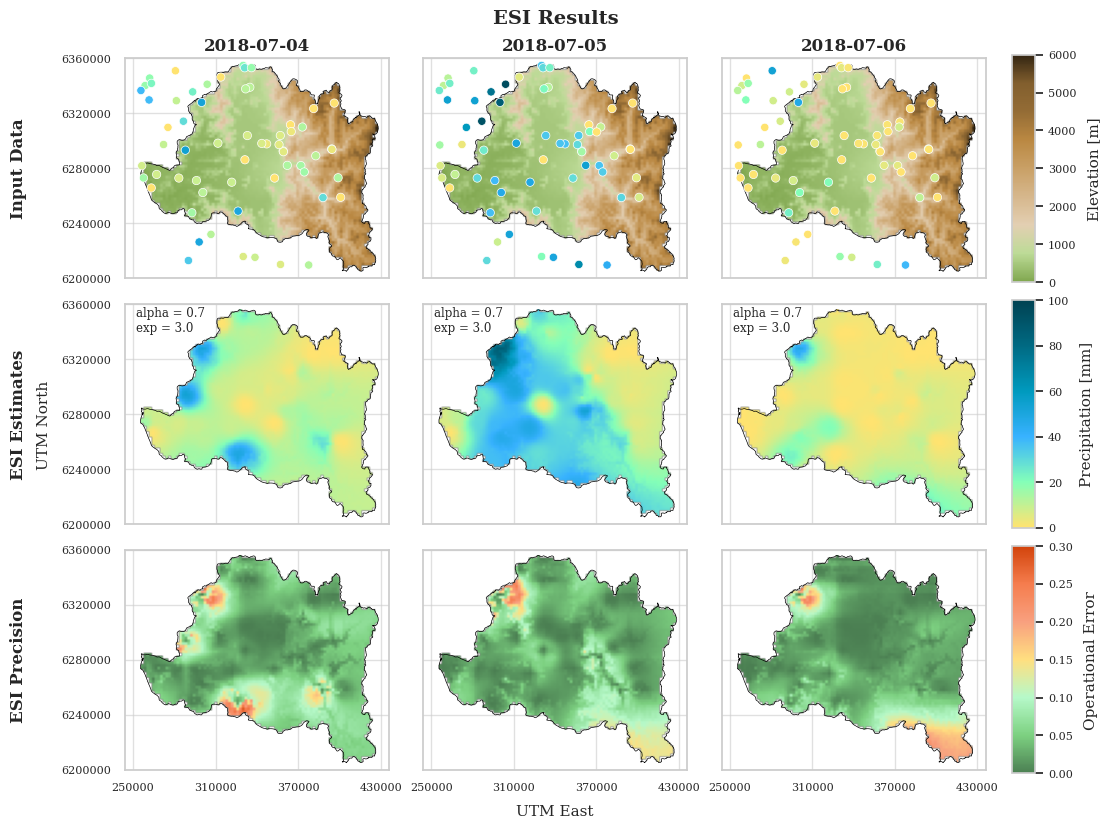

In [5]:
# Visualizing the results
case_study.plot_esi_results(esi_results, parameters_idw)
plt.show()


The produced maps are consistent with the region's precipitation patterns-influenced by the Andes and the Costal Range - and accurately reproduce the values at the sampled locations. The estimates show reasonable values and spatial structure, effectively handling extreme values and abrupt transitions for all three dates.

The operational error values are reasonable, showing higher uncertainty at areas with less data.

## Comparing with other interpolators
We will now compare ESI with other spatial interpolation algorithms. Nearest Neighbor and Radial Basis Function will be implemented using the Scipy library, and Kriging will be applied using PyKrige.

>The deterministic interpolators match Spatialize's ease of use, but do not offer uncertainty estimations.

In [17]:
# To store results
results = case_study.locs.copy()
results.columns = pd.MultiIndex.from_tuples([(x, '', '') for x in results.columns])

# Store ESI results:
for date in case_study.dates:
    results[('esi', date, 'value')] = esi_results[(date, 'value')]

# === Kriging ===
# Grid search to find optimal parameters
param_dict = {
    "method": ["ordinary3d", "universal3d"],
    "variogram_model": ["linear", "power", "gaussian", "spherical"],
    "nlags": [4, 6, 8],
    "n_closest_points": [3, 5, 10, 15]
    }

grid_search = GridSearchCV(Krige(), param_dict, verbose = True)

# Execute kriging with optimized parameters
for date in case_study.dates:
    with SuppressOutput():
        grid_search.fit(X = points[date], y = values[date])
    print("best_params = ", grid_search.best_params_)

    kriging = Krige(**grid_search.best_params_)
    kriging.fit(points[date], values[date])
    results[('kriging', date, 'value')] = kriging.predict(xi)

# === Deterministic interpolators ===
# Interpolate using Scipy
for date in case_study.dates:
    results[('nearest', date, 'value')] = griddata(points[date], values[date], xi, method = 'nearest')
    results[('rbf', date, 'value')]  = RBFInterpolator(points[date], values[date])(xi)

best_params =  {'method': 'ordinary3d', 'n_closest_points': 10, 'nlags': 6, 'variogram_model': 'linear'}
best_params =  {'method': 'ordinary3d', 'n_closest_points': 10, 'nlags': 6, 'variogram_model': 'spherical'}
best_params =  {'method': 'universal3d', 'n_closest_points': 3, 'nlags': 6, 'variogram_model': 'linear'}
n_closest_points will be ignored for UniversalKriging


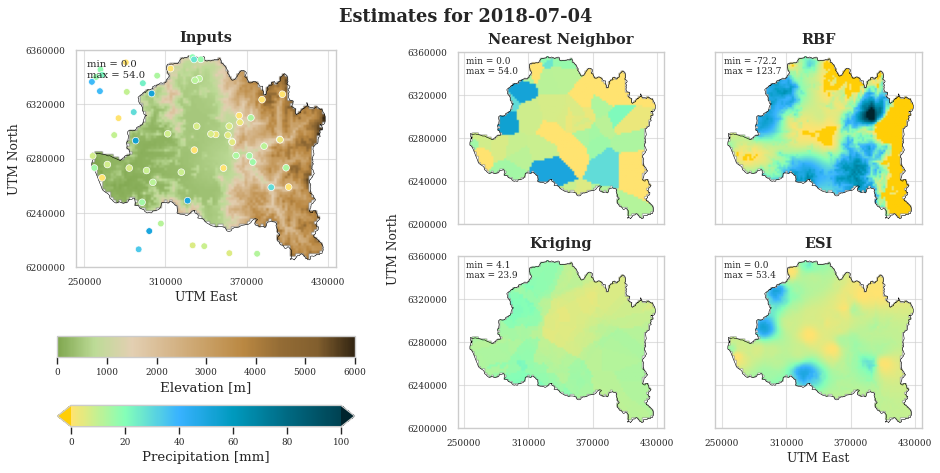

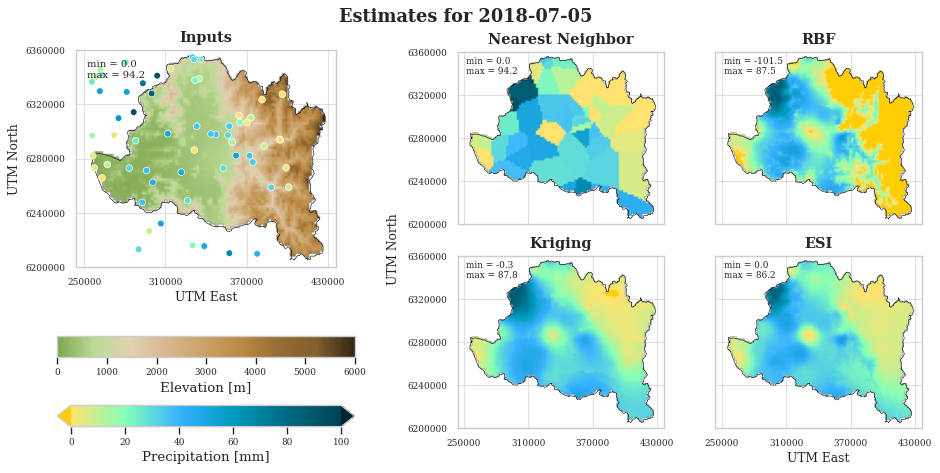

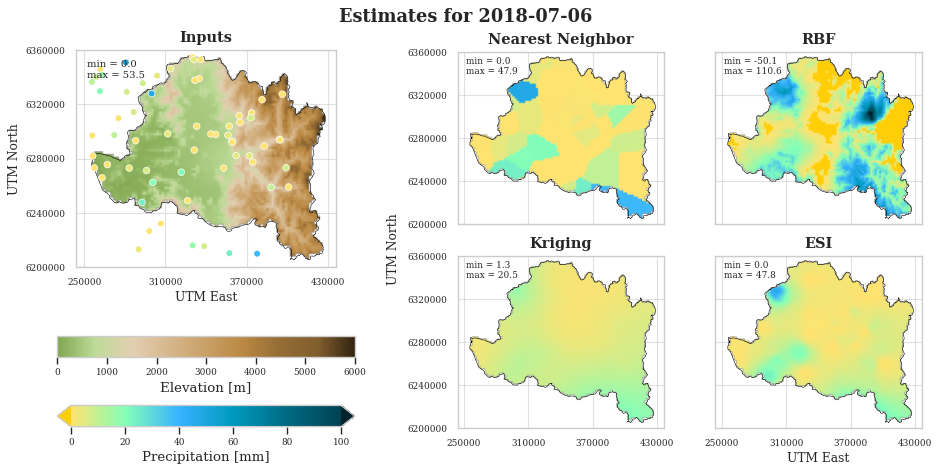

In [18]:
# PLOTTING THE RESULTS
for date in case_study.dates:
    fig, subfigs, ax0, axs = case_study.plot_model_comparison(results, date, dpi=80)
    plt.show()


As previously observed, ESI estimates show reasonable values and spatial structure, effectively handling extreme values and abrupt transitions for all three dates.
It can be seen that the the other models encounter difficulties in this complex scenario:
- Nearest Neighbor interpolations exhibit abrupt boundaries
- RBF interpolators significantly exceed the observed data ranges
- Kriging estimates show a considerable degree of smoothing, completely ignoring the maximum values in two out three dates